40
40
40
40


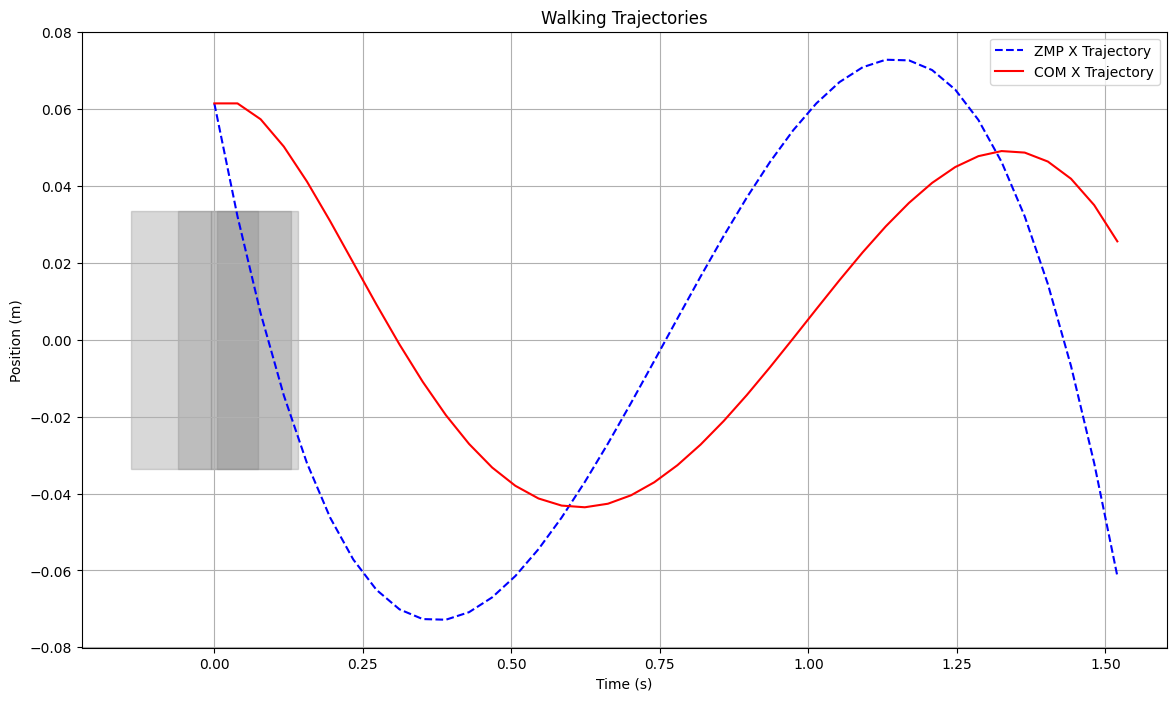

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

G = 9.81
DT = 0.005

# POSTURE
COM_HEIGHT = 0.349
FOOT_HEIGHT = 0.04

# FEET
FEET_SPACING = 0.12294
FOOT_LENGTH = 0.135
FOOT_WIDTH = 0.067

# TIMING
SSP_DURATION = 0.38
SSP_TIMESTEPS = 10
PLANNED_TIMESTEPS = 48

# TESTING
STEPS = 4

def generate_zmp_points():
  zmp_points = []
  for step in range(STEPS):
    if step % 2 == 0:
      # Left foot support
      zmp_points.append([FEET_SPACING / 2, 0.0])
    else:
      # Right foot support
      zmp_points.append([-FEET_SPACING / 2, 0.0])
    
  return np.array(zmp_points)

def interpolate_zmp(zmp_points):
  total_timesteps = SSP_TIMESTEPS * len(zmp_points)
  time_points = np.linspace(0, SSP_DURATION * len(zmp_points), len(zmp_points))
  spline_x = CubicSpline(time_points, zmp_points[:, 0])
  spline_y = CubicSpline(time_points, zmp_points[:, 1])
  
  t_interpolated = np.linspace(0, SSP_DURATION * len(zmp_points), total_timesteps)  
  zmp_trajectory = np.array([spline_x(t_interpolated), spline_y(t_interpolated)]).T
  
  return t_interpolated, zmp_trajectory

def generate_com_trajectory(zmp_trajectory):
    com_trajectory = [zmp_trajectory[0].tolist()]
    for i in range(1, len(zmp_trajectory)):
        acc = (G / COM_HEIGHT) * (np.array(zmp_trajectory[i - 1]) - np.array(com_trajectory[i - 1]))
        com_trajectory.append((np.array(com_trajectory[i - 1]) + acc * DT).tolist())
    return np.array(com_trajectory)

def generate_foot_trajectory():
  swing_trajectory = []
  for step in range(STEPS):
    step_trajectory = []
    
    for t in range(SSP_TIMESTEPS):
      if t < SSP_TIMESTEPS // 2:
        # Rising
        height = FOOT_HEIGHT * (t / (SSP_TIMESTEPS // 2))
      else:
        # FALLING
        height = FOOT_HEIGHT * (1 - (t - SSP_TIMESTEPS // 2) / (SSP_TIMESTEPS // 2))
        
      x = (FEET_SPACING / 2) * (-1 if step % 2 == 0 else 1)  # Step offset
      
      step_trajectory.append([x, 0, height])
    
    swing_trajectory.extend(step_trajectory) 
  return np.array(swing_trajectory)

def visualize_trajectories(t_interp, zmp_trajectory, com_trajectory):
    plt.figure(figsize=(14, 8))

    # ZMP Trajectory
    plt.plot(t_interp, zmp_trajectory[:, 0], label="ZMP X Trajectory", color="blue", linestyle="--")

    # COM Trajectory
    plt.plot(t_interp, com_trajectory[:, 0], label="COM X Trajectory", color="red")

    # Support Polygon (gray rectangles)
    for i, zmp in enumerate(zmp_trajectory[::SSP_TIMESTEPS]):
        x = zmp[0]
        y = zmp[1]
        plt.gca().add_patch(plt.Rectangle(
            (x - FOOT_LENGTH / 2, y - FOOT_WIDTH / 2),
            FOOT_LENGTH,
            FOOT_WIDTH,
            edgecolor='gray',
            facecolor='gray',
            alpha=0.3
        ))

    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Walking Trajectories")
    plt.legend()
    plt.grid()
    plt.show()


zmp_waypoints = generate_zmp_points()
t_interp, zmp_trajectory = interpolate_zmp(zmp_waypoints)
com_trajectory = generate_com_trajectory(zmp_trajectory)
foot_trajectory = generate_foot_trajectory()

print(len(zmp_trajectory))
print(len(com_trajectory))
print(len(foot_trajectory))
print(len(t_interp))

visualize_trajectories(t_interp, zmp_trajectory, com_trajectory)

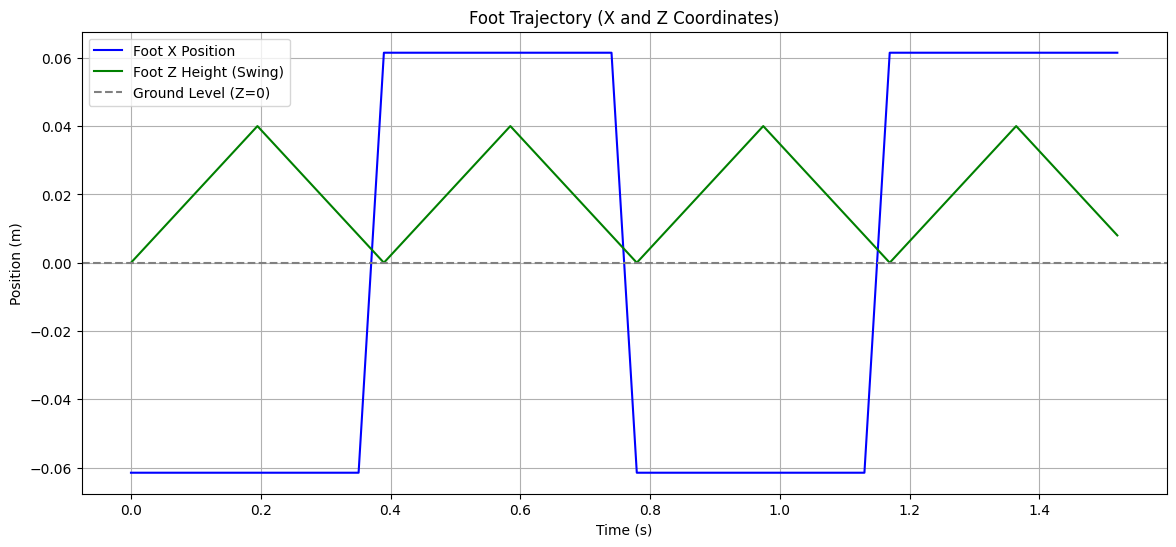

In [16]:
def visualize_foot_trajectory_3d(t_interp, foot_trajectory):
    plt.figure(figsize=(14, 6))

    # Foot trajectory in Z
    plt.plot(t_interp, foot_trajectory[:, 0], label="Foot X Position", color="blue")
    plt.plot(t_interp, foot_trajectory[:, 2], label="Foot Z Height (Swing)", color="green")
    plt.axhline(y=0, color="gray", linestyle="--", label="Ground Level (Z=0)")

    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Foot Trajectory (X and Z Coordinates)")
    plt.legend()
    plt.grid()
    plt.show()
    
visualize_foot_trajectory_3d(t_interp, foot_trajectory)